# 1트 (73.10%)
MNIST 하던 대로, 다만 은닉층을 좀 더 깊게

In [ ]:
!pip install torchmetrics

from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchsummary
import torchmetrics
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from math import *
from copy import deepcopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 8.9 MB/s eta 0:00:00


In [ ]:
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/ml-class-rhseung/data/'
# data_dir = './data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

Mounted at /content/drive


device(type='cuda')

In [ ]:
train_and_valid_dset = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_dset = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class_maps = train_and_valid_dset.classes

X = np.array(train_and_valid_dset.data).transpose(0, 3, 1, 2)
Y = np.array(train_and_valid_dset.targets)

X.shape, Y.shape

((50000, 3, 32, 32), (50000,))

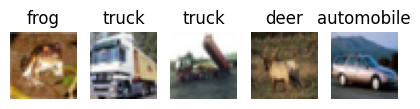

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(5, 2))

for i in range(ax.shape[0]):
    ax[i].imshow(X[i].transpose(1, 2, 0))   # .imshow 는 (32, 32, 3) 형식으로 받아야 한다고 함
    ax[i].set_title(class_maps[Y[i]])
    ax[i].axis('off')

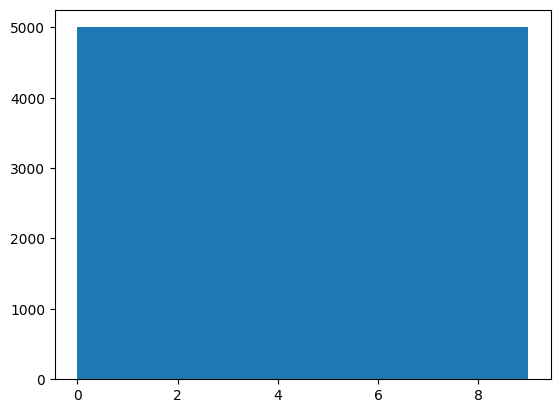

In [ ]:
plt.hist(Y)
plt.show()

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=224, stratify=Y)

X_train.shape, Y_train.shape

((40000, 3, 32, 32), (40000,))

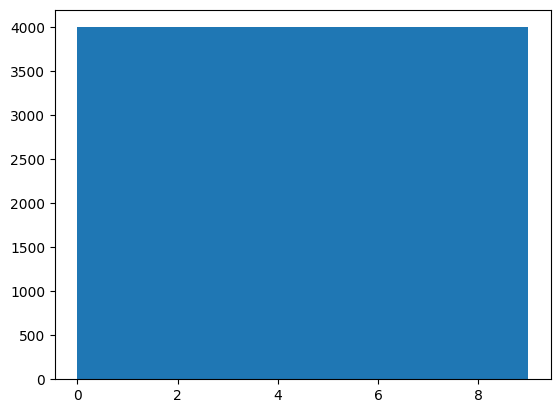

In [ ]:
plt.hist(Y_train)
plt.show()

In [ ]:
X_train = X_train / 255
X_valid = X_valid / 255

X_train.max()

1.0

In [ ]:
X_test = torch.FloatTensor(np.array(test_dset.data).transpose(0, 3, 1, 2)).to(device) / 255
Y_test = torch.LongTensor(test_dset.targets).to(device)

X_test.max()

tensor(1., device='cuda:0')

In [ ]:
class CIFAR10Dataset(Dataset):
    def __init__(self, X_data, Y_data, device=torch.device('cpu')):
        self.X = torch.FloatTensor(X_data).to(device)
        self.Y = torch.LongTensor(Y_data).to(device)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, item):
        if not isinstance(item, int):
            raise TypeError

        return self.X[item], self.Y[item]

train_dset = CIFAR10Dataset(X_train, Y_train, device=device)
valid_dset = CIFAR10Dataset(X_valid, Y_valid, device=device)

In [ ]:
batch_size = 32

train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
list(map(lambda p: p.shape, next(iter(train_loader))))

[torch.Size([32, 3, 32, 32]), torch.Size([32])]

In [ ]:
def model_maker():
    return nn.Sequential(
        # [-1, 3, 32, 32] -> [-1, 64, 16, 16]
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # [-1, 64, 16, 16] -> [-1, 256, 8, 8]
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # [-1, 256, 8, 8] -> [-1, 256*8*8]
        nn.Flatten(start_dim=1),

        # [-1, 256*8*8] -> [-1, 10]
        nn.Linear(256*8*8, 256),
        nn.Linear(256, len(class_maps)),
    ).to(device)

model = model_maker()
cost = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
print(X[0].shape)
torchsummary.summary(model, X[0].shape)

(3, 32, 32)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 256, 16, 16]         295,168
              ReLU-9          [-1, 256, 16, 16]               0
        MaxPool2d-10            [-1, 256, 8, 8]               0
          Flatten-11                [-1, 16384]               0
           Linear-12                  [-1, 256]       4,194,560
           Linear-13                   [-1, 10]           2,570
Total params: 4,585,546
Tra

In [ ]:
epochs = 15

best_epoch = -1
best_model_state = None
best_valid_loss = inf

for epoch in range(epochs):
    with tqdm(train_loader, unit='batch') as train:
        for x, y in train:
            train.set_description(f"Train (Epoch {epoch + 1:02d})")

            optimizer.zero_grad()
            predict = model(x)
            loss = cost(predict, y)
            loss.backward()
            optimizer.step()

            train.set_postfix(loss=loss.item())

    with tqdm(valid_loader, unit='batch') as valid:
        batch_loss = 0

        for x, y in valid:
            valid.set_description(f"Valid (Epoch {epoch + 1:02d})")

            with torch.no_grad():
                predict = model(x)
                loss = cost(predict, y)
                batch_loss += loss.item() / len(valid)

            valid.set_postfix(loss=batch_loss, best_epoch=best_epoch + 1)

        if (not best_model_state) or batch_loss < best_valid_loss:
            best_epoch = epoch
            best_model_state = deepcopy(model.state_dict())
            best_valid_loss = batch_loss

print(f"\n\nBest Epoch: {best_epoch + 1} [loss={best_valid_loss}]")
torch.save(best_model_state, 'best_model.pth')

Valid (Epoch 15): 100%|██████████| 312/312 [00:01<00:00, 159.35batch/s, best_epoch=5, loss=1.69]




Best Epoch: 5 [loss=0.8121935328803003]


In [ ]:
best_model = model_maker()
best_model.load_state_dict(torch.load('best_model.pth'))

with torch.no_grad():
    output = best_model(X_test)
    predict = output.argmax(dim=1)
    is_correct = predict == Y_test

    print(f"Accuracy: {is_correct.float().mean()}")

Accuracy: 0.7310000061988831


# 2트 (53.27%)
1트 + 이미지 정규화

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from google.colab import drive
import numpy as np

drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/ml-class-rhseung/data/'
# data_dir = './data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


device(type='cuda')

In [ ]:
tmp_data = datasets.CIFAR10(
    root='./',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

X_tmp = tmp_data.data / 255

X_tmp.shape

Files already downloaded and verified


(50000, 32, 32, 3)

In [ ]:
r = X_tmp[:, :, :, 0]
g = X_tmp[:, :, :, 1]
b = X_tmp[:, :, :, 2]
channels = [r, g, b]
mean = [x.mean() for x in channels]
std = [x.std() for x in channels]

mean, std

([0.49139967861519745, 0.4821584083946076, 0.44653091444546616],
 [0.2470322324632823, 0.24348512800005553, 0.2615878417279641])

In [ ]:
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.ToPILImage(),
])

In [ ]:
train_data = datasets.CIFAR10(
    root='./',
    train=True,
    download=True,
    transform=normalize
)

X = train_data.data / 255
Y = np.array(train_data.targets)
class_maps = train_data.classes

X.shape, Y.shape

Files already downloaded and verified


((50000, 32, 32, 3), (50000,))

dataset.data는 transform 되기 전의 원본 데이터를 의미하는구나

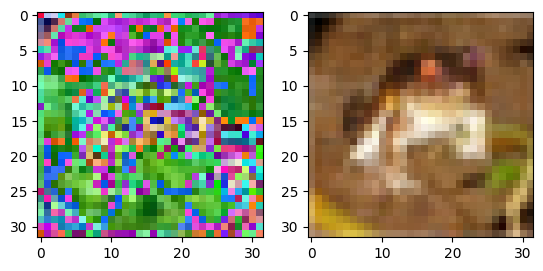

In [ ]:
import matplotlib.pyplot as plt

img, label = next(iter(train_data))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(train_data.data[0])

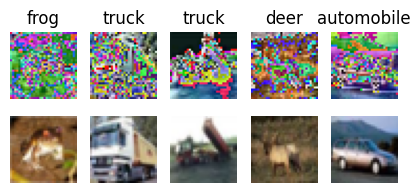

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 5, figsize=(5, 2))

for i in range(ax.shape[1]):
    ax[0, i].imshow(normalize(X[i]))
    ax[0, i].axis('off')
    ax[0, i].set_title(class_maps[Y[i]])

    ax[1, i].imshow(X[i])
    ax[1, i].axis('off')

plt.show()

In [ ]:
X = np.array([np.asarray(normalize(a)) / 255 for a in X]).transpose(0, 3, 1, 2)
X.shape

(50000, 3, 32, 32)

In [ ]:
from sklearn.model_selection import train_test_split

test_data = datasets.CIFAR10(
    root='./',
    train=False,
    download=True,
    transform=normalize
)

X_test = test_data.data / 255
X_test = np.array([np.asarray(normalize(a)) / 255 for a in X_test]).transpose(0, 3, 1, 2)
Y_test = np.array(test_data.targets)
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=224, stratify=Y)

print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"X_valid: {X_valid.shape}, Y_valid: {Y_valid.shape}")
print(f"X_test: {X_test.shape}, Y_test: {Y_test.shape}")

Files already downloaded and verified
X_train: (40000, 3, 32, 32), Y_train: (40000,)
X_valid: (10000, 3, 32, 32), Y_valid: (10000,)
X_test: (10000, 3, 32, 32), Y_test: (10000,)


In [ ]:
X_train.max(), X_valid.max(), X_test.max()

(1.0, 1.0, 1.0)

In [ ]:
from torch.utils.data import DataLoader, Dataset

class CIFAR10Dataset(Dataset):
    def __init__(self, X_data, Y_data, device=torch.device('cpu')):
        self.X = torch.FloatTensor(X_data).to(device)
        self.Y = torch.LongTensor(Y_data).to(device)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, item):
        if not isinstance(item, int):
            raise TypeError

        return self.X[item], self.Y[item]

train_dset = CIFAR10Dataset(X_train, Y_train, device=device)
valid_dset = CIFAR10Dataset(X_valid, Y_valid, device=device)

In [ ]:
batch_size = 32

train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
list(map(lambda p: p.shape, next(iter(train_loader))))

[torch.Size([32, 3, 32, 32]), torch.Size([32])]

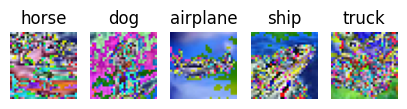

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(5, 2))

for i in range(ax.shape[0]):
    ax[i].imshow(X_train[i].transpose(1, 2, 0))   # .imshow 는 (32, 32, 3) 형식으로 받아야 한다고 함
    ax[i].set_title(class_maps[Y_train[i]])
    ax[i].axis('off')

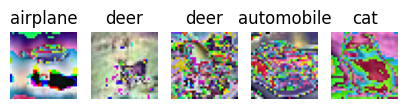

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(5, 2))

for i in range(ax.shape[0]):
    ax[i].imshow(X_valid[i].transpose(1, 2, 0))   # .imshow 는 (32, 32, 3) 형식으로 받아야 한다고 함
    ax[i].set_title(class_maps[Y_valid[i]])
    ax[i].axis('off')

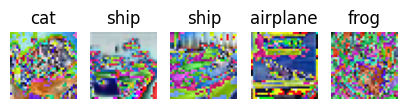

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(5, 2))

for i in range(ax.shape[0]):
    ax[i].imshow(X_test[i].transpose(1, 2, 0))   # .imshow 는 (32, 32, 3) 형식으로 받아야 한다고 함
    ax[i].set_title(class_maps[Y_test[i]])
    ax[i].axis('off')

In [ ]:
import torch.optim as optim
import torchsummary
from tqdm import tqdm
from math import *
from copy import deepcopy

def ConvLayer(in_channels, hidden_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, hidden_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

def model_maker():
    # return nn.Sequential(
    #     # [-1, 3, 32, 32] -> [-1, 256, 4, 4]
    #     ConvLayer(3, 16, 32),
    #     ConvLayer(32, 64, 128),
    #     ConvLayer(128, 128, 256),

    #     nn.Flatten(start_dim=1),

    #     # [-1, 128*8*8] -> [-1, 10]
    #     nn.Linear(256*4*4, 256*4),
    #     # nn.ReLU(),
    #     nn.Linear(256*4, 256),
    #     # nn.ReLU(),
    #     nn.Linear(256, len(class_maps)),
    #     # nn.ReLU()
    # )

    return nn.Sequential(
        # [-1, 3, 32, 32] -> [-1, 64, 16, 16]
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # [-1, 64, 16, 16] -> [-1, 256, 8, 8]
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # [-1, 256, 8, 8] -> [-1, 256*8*8]
        nn.Flatten(start_dim=1),

        # [-1, 256*8*8] -> [-1, 10]
        nn.Linear(256*8*8, 256),
        nn.Linear(256, len(class_maps)),
    )

model = model_maker().to(device)
cost = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
print(X[0].shape)
torchsummary.summary(model, X[0].shape)

(3, 32, 32)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 256, 16, 16]         295,168
              ReLU-9          [-1, 256, 16, 16]               0
        MaxPool2d-10            [-1, 256, 8, 8]               0
          Flatten-11                [-1, 16384]               0
           Linear-12                  [-1, 256]       4,194,560
           Linear-13                   [-1, 10]           2,570
Total params: 4,585,546
Tra

**validation loss가 감소하지 않을 때**

1. 데이터 전처리:  
    데이터를 표준화하고 정규화하자. (배치놈, 스캐일링)
2. 모델 강제성:  
    모델이 너무 복잡한지 확인하자. dropout를 추가하고 각 계층의 레이어 수 또는 뉴런 수를 줄이자.
3. 학습률 및 학습률 감소 속도:  
    learning rate를 줄이자. 학습을 하기에 좋은 lr은 보통 0.0005에서 0.001 사이다. 또한 1e-6의 학습률 decay rate을 고려하자.

In [ ]:
epochs = 20

best_epoch = -1
best_model_state = None
best_valid_loss = inf

for epoch in range(epochs):
    with tqdm(train_loader, unit='batch') as train:
        for x, y in train:
            train.set_description(f"Train (Epoch {epoch + 1:02d})")

            optimizer.zero_grad()
            predict = model(x)
            loss = cost(predict, y)
            loss.backward()
            optimizer.step()

            train.set_postfix(loss=loss.item())

    with tqdm(valid_loader, unit='batch') as valid:
        batch_loss = 0

        for x, y in valid:
            valid.set_description(f"Valid (Epoch {epoch + 1:02d})")

            with torch.no_grad():
                predict = model(x)
                loss = cost(predict, y)
                batch_loss += loss.item() / len(valid)

            valid.set_postfix(loss=batch_loss, best_epoch=best_epoch + 1)

        if (not best_model_state) or batch_loss < best_valid_loss:
            best_epoch = epoch
            best_model_state = deepcopy(model.state_dict())
            best_valid_loss = batch_loss

print(f"\n\nBest Epoch: {best_epoch + 1} [loss={best_valid_loss}]")
torch.save(best_model_state, 'best_model.pth')

Valid (Epoch 20): 100%|██████████| 312/312 [00:02<00:00, 150.26batch/s, best_epoch=19, loss=1.62]




Best Epoch: 20 [loss=1.6216915773275564]


In [ ]:
best_model = model_maker().to(device)
best_model.load_state_dict(torch.load('best_model.pth'))

if isinstance(X_test, np.ndarray) and isinstance(Y_test, np.ndarray):
    X_test = torch.FloatTensor(X_test).to(device)
    Y_test = torch.LongTensor(Y_test).to(device)
    # X_test, Y_test = test_dset.X, test_dset.Y

with torch.no_grad():
    output = best_model(X_test)
    predict = output.argmax(dim=1)
    is_correct = predict == Y_test

    print(f"Accuracy: {is_correct.float().mean()}")

Accuracy: 0.4172999858856201


# 3트

In [14]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [7]:
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        layers = [
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.pool
        ]

        for layer in layers:
            x = layer(x)

        return x


In [8]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.block1 = BasicBlock(3, 16, 32)
        self.block2 = BasicBlock(32, 64, 128)
        self.block3 = BasicBlock(128, 128, 256)

        self.fc1 = nn.Linear(256*4*4, 256*4*2)
        self.fc2 = nn.Linear(256*4*2, 256)
        self.fc3 = nn.Linear(256, num_classes)

        self.relu = nn.ReLU()
        self.flatten = lambda x: torch.flatten(x, start_dim=1)

    def forward(self, x):
        layers = [
            self.block1,
            self.block2,
            self.block3,
            self.flatten,
            self.fc1,
            self.relu,
            self.fc2,
            self.relu,
            self.fc3
        ]

        for layer in layers:
            x = layer(x)

        return x